In [51]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import math
from tqdm import trange
import matplotlib.pyplot as plt
from collections import Counter
import os
from PIL import Image


In [52]:
# Set random seed for reproducibility
torch.manual_seed(42)


In [35]:
# Define transformations for training data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


In [4]:
# Load MNIST dataset
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST('./data', train=False, transform=transform)

# Load entire training and test datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset))

X_train, Y_train = next(iter(train_loader))
X_test, Y_test = next(iter(test_loader))


In [36]:
# Define the SafetySetDataset class
class SafetySetDataset(torch.utils.data.Dataset):
    def __init__(self, safety_set_path, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform
        for file in os.listdir(safety_set_path):
            if file.endswith('.png'):
                label_str = file.split('_label_')[-1].split('.png')[0]
                label = int(label_str)
                image_path = os.path.join(safety_set_path, file)
                self.image_paths.append(image_path)
                self.labels.append(label)
                
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('L')
        if self.transform:
            image = self.transform(image)
        else:
            image = transform(image)  # Default transform
        label = self.labels[idx]
        return image, label


In [37]:
# Path to the safety set folder (update with your actual path)
safety_set_path = '/home/mohammad/Safety-Driven-Self-Compressing-Neural-Networks/Computer Vision/XAI/safety_set_images_d'  # Replace with your actual safety set directory

# Transform for the safety set images
safety_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Create the safety set dataset and loader
safety_dataset = SafetySetDataset(safety_set_path, transform=safety_transform)
safety_loader = torch.utils.data.DataLoader(safety_dataset, batch_size=len(safety_dataset), shuffle=False)

# Load the entire safety set
try:
    X_safety, Y_safety = next(iter(safety_loader))
    print(f"Safety set size: {X_safety.shape[0]} samples")
except StopIteration:
    print("Safety set is empty or path is incorrect.")
    X_safety, Y_safety = torch.Tensor(), torch.Tensor()


Safety set size: 1000 samples


In [53]:
# Define the quantized convolutional layer
class QConv2d(nn.Module):
    """
    Quantized Conv2d layer starting with 2 bits per weight
    """
    def __init__(self, in_channels, out_channels, kernel_size):
        super(QConv2d, self).__init__()
        self.kernel_size = (kernel_size, kernel_size) if isinstance(kernel_size, int) else tuple(kernel_size)
        scale = 1 / math.sqrt(in_channels * math.prod(self.kernel_size))
        self.weight = nn.Parameter(torch.empty(out_channels, in_channels, *self.kernel_size).uniform_(-scale, scale))
        self.e = nn.Parameter(torch.full((out_channels, 1, 1, 1), -8.))
        self.b = nn.Parameter(torch.full((out_channels, 1, 1, 1), 2.))  # Start with 2 bits per weight

    def qbits(self):
        return self.b.relu().sum() * math.prod(self.weight.shape[1:])

    def qweight(self):
        min_val = -2 ** (self.b.relu() - 1)
        max_val = 2 ** (self.b.relu() - 1) - 1
        scaled_weight = 2 ** -self.e * self.weight
        qweight = torch.clamp(scaled_weight, min_val, max_val)
        return qweight

    def forward(self, x):
        qw = self.qweight()
        w = (qw.round() - qw).detach() + qw  # Straight-through estimator
        return nn.functional.conv2d(x, 2 ** self.e * w)


In [56]:
# Define the CNN model using quantized convolutional layers
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.features = nn.Sequential(
            QConv2d(1, 32, 5), nn.ReLU(),           # Output: (batch_size, 32, 24, 24)
            QConv2d(32, 32, 5), nn.ReLU(),          # Output: (batch_size, 32, 20, 20)
            nn.BatchNorm2d(32, affine=False, track_running_stats=False),
            nn.MaxPool2d(2),                        # Output: (batch_size, 32, 10, 10)
            QConv2d(32, 64, 3), nn.ReLU(),          # Output: (batch_size, 64, 8, 8)
            QConv2d(64, 64, 3), nn.ReLU(),          # Output: (batch_size, 64, 6, 6)
            nn.BatchNorm2d(64, affine=False, track_running_stats=False),
            nn.MaxPool2d(2)                         # Output: (batch_size, 64, 3, 3)
        )
        self.classifier = nn.Linear(64 * 3 * 3, 10)  # 64 channels, 3x3 feature map

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)
        return x

    def qbits(self):
        return sum(l.qbits() for l in self.features if isinstance(l, QConv2d))


In [57]:
# Instantiate the model and define optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model().to(device)
opt = optim.Adam(model.parameters())
weight_count = sum(p.numel() for p in model.parameters() if p.requires_grad)


In [58]:
# Define the training step function
def train_step():
    model.train()
    opt.zero_grad()
    # Main training batch
    samples = torch.randint(0, X_train.shape[0], (512,))
    outputs = model(X_train[samples].to(device))
    loss = nn.functional.cross_entropy(outputs, Y_train[samples].to(device))
    Q = model.qbits() / weight_count
    loss = loss + 0.05 * Q  # Hyperparameter determines compression vs accuracy

    # Safety set penalty
    if X_safety.numel() > 0:
        safety_indices = torch.randint(0, X_safety.shape[0], (64,))
        safety_images_batch = X_safety[safety_indices].to(device)
        safety_labels_batch = Y_safety[safety_indices].to(device)
        safety_outputs = model(safety_images_batch)
        safety_loss = nn.functional.cross_entropy(safety_outputs, safety_labels_batch)
        safety_weight = 0.1  # Adjust this weight as needed
        loss = loss + safety_weight * safety_loss
    else:
        safety_loss = 0.0

    loss.backward()
    opt.step()
    return loss.item(), Q.item(), safety_loss if isinstance(safety_loss, float) else safety_loss.item()


In [59]:
# Function to get test accuracy
def get_test_acc():
    model.eval()
    with torch.no_grad():
        outputs = model(X_test.to(device))
        pred = outputs.argmax(dim=1)
        return (pred == Y_test.to(device)).float().mean().item() * 100


In [60]:
# Function to restore kernels (adjust 'b' parameter)
def restore_kernels(restore_fraction=0.5):
    # Restore 'b' for a fraction of QConv2d layers
    qconv_layers = [l for l in model.features if isinstance(l, QConv2d)]
    num_layers = len(qconv_layers)
    num_restore = int(restore_fraction * num_layers)
    for l in qconv_layers[:num_restore]:
        # Increase 'b' to a higher value (e.g., set minimum b)
        with torch.no_grad():
            l.b.data = torch.clamp(l.b.data, min=2.0)


In [61]:
# Initialize variables for the training loop
prev_safety_acc = 100.0  # Initialize with 100%
safety_acc_drop_threshold = 10  # Acceptable accuracy drop (e.g., 1%)
restore_fraction = 0.1  # Restore 50% of kernels when necessary

test_acc = 0.0
test_accs, bytes_used, safety_accs = [], [], []


In [62]:
from tqdm import trange

# Training loop
for i in trange(4000):
    loss, Q, safety_loss = train_step()
    model_bytes = Q / 8 * weight_count  # Convert from bits to bytes
    if i % 10 == 9:
        test_acc = get_test_acc()
        safety_acc = get_safety_acc()
        acc_drop = prev_safety_acc - safety_acc
        if acc_drop > safety_acc_drop_threshold:
            # Restore kernels
            restore_kernels(restore_fraction=restore_fraction)
        prev_safety_acc = safety_acc
        test_accs.append(test_acc)
        bytes_used.append(model_bytes)
        safety_accs.append(safety_acc)
    else:
        # Use the previous test accuracy and safety accuracy
        if test_accs:
            test_accs.append(test_accs[-1])
            bytes_used.append(model_bytes)
            safety_accs.append(prev_safety_acc)
        else:
            test_accs.append(0.0)
            bytes_used.append(model_bytes)
            safety_accs.append(prev_safety_acc)
    
    if i % 100 == 99:
        print(f"Iteration {i+1}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.2f}%, Safety Accuracy: {prev_safety_acc:.2f}%, Model Size: {model_bytes:.2f} bytes")


  3%|▎         | 102/4000 [00:09<06:39,  9.76it/s]

Iteration 100, Loss: 1.8362, Test Accuracy: 74.69%, Safety Accuracy: 25.80%, Model Size: 20897.97 bytes


  5%|▌         | 202/4000 [00:18<06:28,  9.77it/s]

Iteration 200, Loss: 0.7035, Test Accuracy: 88.70%, Safety Accuracy: 35.90%, Model Size: 21744.51 bytes


  8%|▊         | 302/4000 [00:28<06:18,  9.77it/s]

Iteration 300, Loss: 0.5707, Test Accuracy: 92.30%, Safety Accuracy: 40.30%, Model Size: 21995.63 bytes


 10%|█         | 402/4000 [00:37<06:08,  9.78it/s]

Iteration 400, Loss: 0.6607, Test Accuracy: 92.61%, Safety Accuracy: 40.10%, Model Size: 22074.83 bytes


 13%|█▎        | 502/4000 [00:47<05:59,  9.74it/s]

Iteration 500, Loss: 0.5265, Test Accuracy: 90.62%, Safety Accuracy: 43.20%, Model Size: 22098.18 bytes


 15%|█▌        | 602/4000 [00:56<05:49,  9.73it/s]

Iteration 600, Loss: 0.6632, Test Accuracy: 90.88%, Safety Accuracy: 40.90%, Model Size: 22084.52 bytes


 18%|█▊        | 702/4000 [01:06<05:38,  9.74it/s]

Iteration 700, Loss: 0.5922, Test Accuracy: 93.66%, Safety Accuracy: 42.20%, Model Size: 22068.85 bytes


 20%|██        | 802/4000 [01:15<05:27,  9.77it/s]

Iteration 800, Loss: 0.4676, Test Accuracy: 93.92%, Safety Accuracy: 41.20%, Model Size: 22058.06 bytes


 23%|██▎       | 902/4000 [01:25<05:17,  9.75it/s]

Iteration 900, Loss: 0.6270, Test Accuracy: 91.18%, Safety Accuracy: 42.50%, Model Size: 22043.03 bytes


 25%|██▌       | 1002/4000 [01:34<05:09,  9.70it/s]

Iteration 1000, Loss: 0.4581, Test Accuracy: 93.85%, Safety Accuracy: 43.00%, Model Size: 22028.95 bytes


 28%|██▊       | 1102/4000 [01:44<05:01,  9.62it/s]

Iteration 1100, Loss: 0.5564, Test Accuracy: 94.36%, Safety Accuracy: 45.00%, Model Size: 22013.38 bytes


 30%|███       | 1202/4000 [01:53<04:47,  9.74it/s]

Iteration 1200, Loss: 0.4941, Test Accuracy: 92.87%, Safety Accuracy: 40.30%, Model Size: 21998.52 bytes


 33%|███▎      | 1302/4000 [02:03<04:36,  9.75it/s]

Iteration 1300, Loss: 0.5097, Test Accuracy: 95.37%, Safety Accuracy: 43.70%, Model Size: 21972.96 bytes


 35%|███▌      | 1402/4000 [02:12<04:26,  9.74it/s]

Iteration 1400, Loss: 0.4966, Test Accuracy: 93.90%, Safety Accuracy: 41.90%, Model Size: 21953.83 bytes


 38%|███▊      | 1502/4000 [02:21<04:16,  9.75it/s]

Iteration 1500, Loss: 0.4698, Test Accuracy: 95.05%, Safety Accuracy: 44.10%, Model Size: 21938.77 bytes


 40%|████      | 1602/4000 [02:31<04:07,  9.71it/s]

Iteration 1600, Loss: 0.5069, Test Accuracy: 94.66%, Safety Accuracy: 44.70%, Model Size: 21916.31 bytes


 40%|████      | 1619/4000 [02:33<03:45, 10.57it/s]


KeyboardInterrupt: 

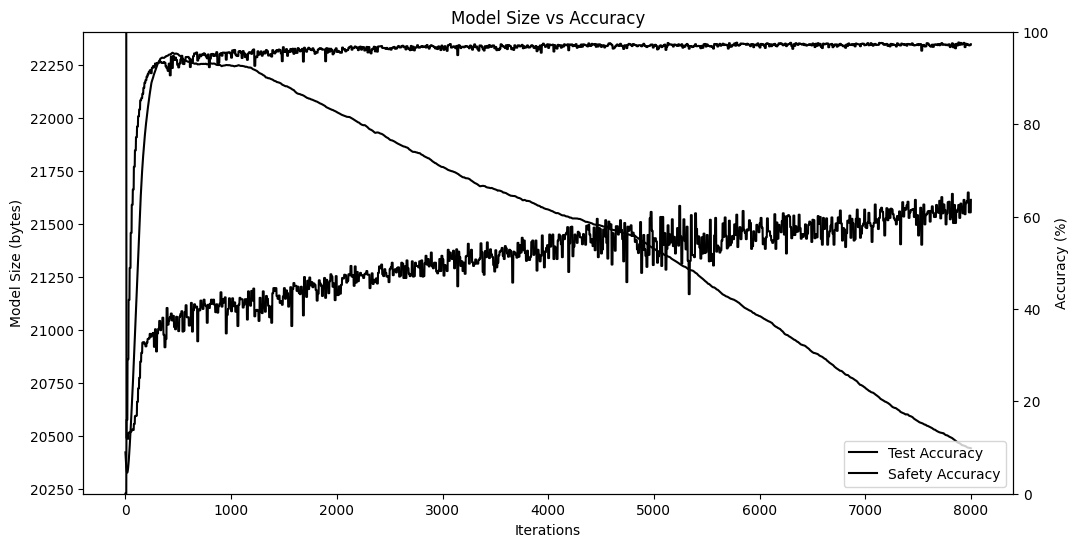

In [49]:
# Plot Model Size vs Test Accuracy and Safety Accuracy
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot model size
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Model Size (bytes)', color='k')
ax1.plot(bytes_used, color='k')
ax1.tick_params(axis='y', labelcolor='k')

# Plot accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy (%)', color='k')
ax2.plot(test_accs, color='k', label='Test Accuracy')
ax2.plot(safety_accs, color='k', label='Safety Accuracy')
ax2.tick_params(axis='y', labelcolor='k')
ax2.set_ylim(0, 100)
ax2.legend(loc='lower right')

plt.title('Model Size vs Accuracy')
plt.show()


In [17]:
# Sanity check for 'b' and 'e' parameters
for name, param in model.named_parameters():
    if name.endswith(".b") or name.endswith(".e"):
        print(name, param.shape, param.detach().cpu().numpy().flatten()[:10])

# Check quantized weights distribution
for i, l in enumerate(model.features):
    if isinstance(l, QConv2d):
        weight_values = l.qweight().round().detach().cpu().numpy().flatten()
        counts = Counter(weight_values.tolist())
        print(f"QConv2d Layer {i} weight distribution:")
        for value, count in counts.items():
            print(f"Value: {value}, Count: {count}")


features.0.e torch.Size([32, 1, 1, 1]) [-8.251696  -8.147886  -7.5014095 -7.7495756 -8.836044  -9.02292
 -8.201351  -8.084957  -7.7400784 -7.529376 ]
features.0.b torch.Size([32, 1, 1, 1]) [2.3218088 2.4803293 2.3041418 2.3093002 1.98423   2.0000312 1.9899176
 2.3199558 2.5888402 2.7653239]
features.2.e torch.Size([32, 1, 1, 1]) [-8.741544  -7.9310026 -8.252103  -8.190645  -8.205617  -8.385294
 -7.9090405 -7.6681013 -8.306162  -8.2327585]
features.2.b torch.Size([32, 1, 1, 1]) [1.9734459 2.3238516 2.0065715 2.01294   2.0340462 2.3220444 2.0917115
 2.3220205 2.3215451 2.3211205]
features.6.e torch.Size([64, 1, 1, 1]) [-7.9400344 -7.921058  -8.011238  -8.427706  -7.7984347 -8.247685
 -7.9578357 -8.063971  -7.902388  -7.9340057]
features.6.b torch.Size([64, 1, 1, 1]) [2.2553372 1.7744656 1.5545745 0.7811079 2.5616229 1.6389004 1.2568418
 1.416695  1.7039486 0.9829472]
features.8.e torch.Size([64, 1, 1, 1]) [-7.859339  -8.131158  -7.9152393 -8.036764  -7.9279113 -8.1334915
 -8.02811   -7.8